In [1]:
import json

import agama
import h5py
import halo_analysis as halo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gc_utils import iteration_name, snapshot_name  # type: ignore
from scipy.interpolate import PchipInterpolator, interp1d

In [2]:
sim = "m12i"

data_dir = "/Users/z5114326/Documents/GitHub/gc_statistics/data/"
data_file = data_dir + "m12i_time_dep.json"

sim_dir = "/Users/z5114326/Documents/simulations/"
pot_dir = "/Users/z5114326/Documents/GitHub/gc_kinematics/data/potentials/"
potential_snaps = "/Users/z5114326/Documents/GitHub/gc_kinematics/data/external/potentials.json"

fire_dir = sim_dir + sim + "/" + sim + "_res7100/"

proc_file = sim_dir + sim + "/" + sim + "_processed.hdf5"
proc_data = h5py.File(proc_file, "r")  # open processed data file

pub_data = sim_dir + "snapshot_times_public.txt"

# 1. set units (in Msun, Kpc, km/s)
agama.setUnits(mass=1, length=1, velocity=1)

with open(data_file, "r") as file:
    data_dict = json.load(file)

with open(potential_snaps) as json_file:
    pot_data = json.load(json_file)

snap_time_pub = pd.read_table(pub_data, comment="#", header=None, sep=r"\s+")
snap_time_pub.columns = [
    "index",
    "scale_factor",
    "redshift",
    "time_Gyr",
    "lookback_time_Gyr",
    "time_width_Myr",
]

res_df = snap_time_pub[snap_time_pub["index"].isin(pot_data[sim])].reset_index(drop=True)

In [35]:
mass_dict = {}
# snap_data = proc_data[it_id]["snapshots"]

it_min = 0
it_max = 0
for it in range(it_min, it_max + 1):
    it_id = iteration_name(it)
    mass_dict[it_id] = {}
    snap_keys = proc_data[it_id]["snapshots"]

    src_data = proc_data[it_id]["source"]
    ana_mask = np.array(src_data["analyse_flag"]) == 1

    surviving_gc_lst = np.array(proc_data[it_id]["snapshots"]["snap600"]["gc_id"])

    mass_dict[it_id]["gc_id"] = []
    mass_dict[it_id]["survive_flag"] = []
    mass_dict[it_id]["time"] = []
    mass_dict[it_id]["time_acc"] = []
    # mass_dict[it_id]["snap_id"] = []
    mass_dict[it_id]["form_time_flag"] = []
    mass_dict[it_id]["mass"] = []
    mass_dict[it_id]["group_id"] = []

    for snap_id in snap_keys:
        snap_data = snap_keys[snap_id]
        time = snap_time_pub[snap_time_pub["index"] == int(snap_id[4:])]["time_Gyr"].values[0]

        if "bound_flag" in snap_data.keys():
            for gc, grp, mass, bnd in zip(
                snap_data["gc_id"], snap_data["group_id"], snap_data["mass"], snap_data["bound_flag"]
            ):
                if bnd == 1:
                    # only looking at exsitu GCs
                    if grp > 0:
                        mass_dict[it_id]["gc_id"].append(gc)
                        mass_dict[it_id]["time"].append(time)

                        idx = np.where(np.array(src_data["gc_id"][ana_mask]) == gc)[0][0]
                        time_acc = src_data["t_acc"][ana_mask][idx]

                        mass_dict[it_id]["time_acc"].append(time - time_acc)
                        # mass_dict[it_id]["snap_id"].append(snap_id)

                        # net yet adding formation details (will do this at the end)
                        mass_dict[it_id]["form_time_flag"].append(0)

                        mass_dict[it_id]["mass"].append(mass)
                        mass_dict[it_id]["group_id"].append(grp)

                        # check if still in snap600
                        if gc in surviving_gc_lst:
                            mass_dict[it_id]["survive_flag"].append(1)
                        else:
                            mass_dict[it_id]["survive_flag"].append(0)

        else:
            for gc, grp, mass in zip(snap_data["gc_id"], snap_data["group_id"], snap_data["mass"]):
                # only looking at exsitu GCs
                if grp > 0:
                    mass_dict[it_id]["gc_id"].append(gc)
                    mass_dict[it_id]["time"].append(time)

                    idx = np.where(np.array(src_data["gc_id"][ana_mask]) == gc)[0][0]
                    time_acc = src_data["t_acc"][ana_mask][idx]

                    mass_dict[it_id]["time_acc"].append(time - time_acc)
                    # mass_dict[it_id]["snap_id"].append(snap_id)

                    # net yet adding formation details (will do this at the end)
                    mass_dict[it_id]["form_time_flag"].append(0)

                    mass_dict[it_id]["mass"].append(mass)
                    mass_dict[it_id]["group_id"].append(grp)

                    # check if still in snap600
                    if gc in surviving_gc_lst:
                        mass_dict[it_id]["survive_flag"].append(1)
                    else:
                        mass_dict[it_id]["survive_flag"].append(0)

In [ ]:
# add formation details
for it in range(it_min, it_max + 1):
    it_id = iteration_name(it)
    gc_lst = np.unique(mass_dict[it_id]["gc_id"])

    src_data = proc_data[it_id]["source"]
    ana_mask = np.array(proc_data[it_id]["source"]["analyse_flag"]) == 1

    surviving_gc_lst = np.array(proc_data[it_id]["snapshots"]["snap600"]["gc_id"])

    for gc in gc_lst:
        idx = np.where(np.array(src_data["gc_id"][ana_mask]) == gc)[0][0]
        time_acc = src_data["t_acc"][ana_mask][idx]
        time_form = src_data["form_time"][ana_mask][idx]
        mass_form = src_data["logm_tform"][ana_mask][idx]
        grp = src_data["group_id"][ana_mask][idx]

        mass_dict[it_id]["gc_id"].append(gc)
        mass_dict[it_id]["time"].append(time_form)
        mass_dict[it_id]["time_acc"].append(time_form - time_acc)

        # is the time of formation
        mass_dict[it_id]["form_time_flag"].append(1)

        # think about whether i multiply this by 0.6 (instant mass loss of 40%)
        # do I want to only think about detectable mass as of now
        mass_dict[it_id]["mass"].append(mass_form)
        mass_dict[it_id]["group_id"].append(grp)

        # check if still in snap600
        if gc in surviving_gc_lst:
            mass_dict[it_id]["survive_flag"].append(1)
        else:
            mass_dict[it_id]["survive_flag"].append(0)


In [144]:
mass_loss_dict = {}

for it in range(it_min, it_max + 1):
    it_id = iteration_name(it)
    mass_loss_dict[it_id] = {}

    mass_loss_dict[it_id]["time_acc"] = []
    mass_loss_dict[it_id]["mass_loss"] = []

    gc_lst = np.unique(mass_dict[it_id]["gc_id"])

    for gc_id in gc_lst:
        gc_mask = mass_dict[it_id]["gc_id"] == gc_id
        gc_mass_lst = np.array(mass_dict[it_id]["mass"])[gc_mask]
        gc_time_lst = np.array(mass_dict[it_id]["time_acc"])[gc_mask]

        gc_sort = np.argsort(gc_time_lst)

        # Sort both arrays using the same indices
        gc_time_lst = gc_time_lst[gc_sort]
        gc_mass_lst = gc_mass_lst[gc_sort]

        for i in range(1, len(gc_mass_lst)):
            past_log_mass = gc_mass_lst[i - 1]
            curr_log_mass = gc_mass_lst[i]

            past_mass = 10**past_log_mass
            curr_mass = 10**curr_log_mass

            curr_time = gc_time_lst[i]

            mass_loss_dict[it_id]["time_acc"].append(curr_time)
            mass_loss_dict[it_id]["mass_loss"].append(past_mass - curr_mass)

            if (past_mass - curr_mass) < 0:
                print(gc_id, past_mass, curr_mass)

13152445 90782.05301781862 165196.1798229015
16392980 149279.44095789976 271643.92688390834
18457605 71779.42912713616 130617.08881318405
25249485 6591.738952443213 11994.993031493781
27069362 10046.157902783947 18281.00216142741
27456138 274789.4153102397 500034.5349769783
27456151 63973.48354826482 116412.60294104909
27461332 6745.280276979222 12274.392311584084
27633152 10351.42166679343 18836.49089489802
27648848 6870.684400142324 12502.590302177214
27811567 67920.36326171843 123594.74334445094
28174863 14927.944095789975 27164.392688390835
28180332 14962.356560944329 27227.0130807791
28194132 6367.955209079156 11587.773561551261
28197819 7379.042301291008 13427.649611378642
28206797 8749.837752274363 15922.0872705117
28753443 6295.061828571975 11455.129414455361
29125146 6067.363295885053 11040.786199020735
29303711 14321.878992735425 26061.53549998898
29493572 13182.567385564074 23988.329190194898
29890926 28641.7796990658 52119.471110508
30059288 8570.378452303692 15595.52502826

### NEED TO MIX -VE MASS LOSS ()

In [114]:
mass_loss_sum_dict = {}

it = 0
it_id = iteration_name(it)

mass_loss_sum_dict[it_id] = {}

time_lst = np.unique(mass_loss_dict[it_id]["time_acc"])
time_lst = np.sort(time_lst)

mass_loss_sum_dict[it_id]["time_acc"] = time_lst
mass_loss_sum_dict[it_id]["mass_loss"] = []

for time in time_lst:
    time_mask = np.where(np.array(mass_loss_dict[it_id]["time_acc"]) == time)[0]
    mass_loss = np.sum(np.array(mass_loss_dict[it_id]["mass_loss"])[time_mask])
    mass_loss_sum_dict[it_id]["mass_loss"].append(mass_loss)

mass_loss_sum_dict[it_id]["mass_loss_cumsum"] = np.cumsum(mass_loss_sum_dict[it_id]["mass_loss"])

In [126]:
gc_lst = np.unique(mass_dict[it_id]["gc_id"])

time_past_acc = 0

for gc in gc_lst:
    gc_mask = mass_dict[it_id]["gc_id"] == gc_id
    gc_time_lst = np.array(mass_dict[it_id]["time_acc"])[gc_mask]

    min_time = np.min(gc_time_lst[gc_time_lst > 0])

    time_past_acc = np.max([time_past_acc, min_time])

print(time_past_acc)

0.07486853500000001


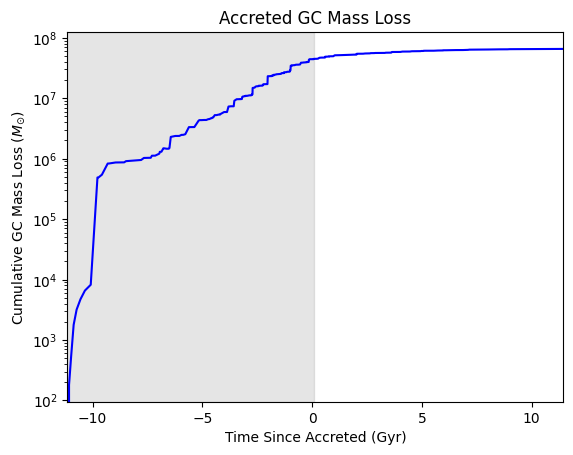

In [145]:
x = mass_loss_sum_dict[it_id]["time_acc"]
y = mass_loss_sum_dict[it_id]["mass_loss_cumsum"]

plt.plot(x, y, c="b")

plt.axvspan(np.min(x), time_past_acc, color="gray", alpha=0.2)

plt.xlabel("Time Since Accreted (Gyr)")
plt.ylabel(r"Cumulative GC Mass Loss ($M_{\odot}$)")

plt.title("Accreted GC Mass Loss")

plt.xlim([np.min(x), np.max(x)])
plt.yscale("log")

In [141]:
np.min(y)

-64217.79508359759